# Test for spectral MC Simulations

In [1]:
import luxpy as lx
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

from empir19nrm02.spectral import McSpectrumX
from empir19nrm02.tools import sumMC, sumMCV
from empir19nrm02.f1prime import py_f1PrimeG

# Parameter for Standard $f_{1}^{'}$

In [2]:
strWeighting = 'A'
strObserver = '1931_2'
iObserverOffset = 1
wlResolution = 5
wlStart = 380
wlStop = 780
trials = 10000

In [3]:
def plotHistScales( data, fig=None, ax=None, bins=50, density=True,
             title='Title', xLabel='xLabel', yLabel=None):

    if ax == None:
        fig, ax1 = plt.subplots()
    else:
        ax1=ax

    ax1.hist(data[1:], bins=bins, density=density)
    ax1.set_xlabel(xLabel)
    ax1.set_title(title)
    if yLabel is None:         
        ax1.set_ylabel('Probability')
    else:
        ax1.set_ylabel(yLabel)
    
    # stat over all
    [value, interval] = sumMC(data, Coverage=0.95)
    print( 'Value=', value, 'Inteval(95%)=', interval[1]-interval[0])

    ax1.axvline(interval[0])
    ax1.axvline(interval[1])
    ax1.axvline(value[0], color='tab:red')
    if ax is None:
        fig.show()

def plotHistScalesWl( data, fig=None, ax=None, bins=50, density=True,
              title =  'Histogram of wavelength scale',
              xLabel = '$\Delta \lambda / nm$'):
    plotHistScales( data,fig=fig, ax=ax, bins=bins, density=density, title=title, xLabel=xLabel)

def plotHistScalesValue( data, fig=None, ax=None, bins=50, density=True,
              title =  'Histogram of value scale',
              xLabel = '$\Delta y / a.u.$'):
    plotHistScales( data, fig=fig, ax=ax, bins=bins, density=density, title=title, xLabel=xLabel)        


In [4]:
def array2analyse(spectrumMC, wavelength_stat = True, scale_to_ref=True):
    _trials=len( spectrumMC)-1
    _res=len(spectrumMC[0].spd.wl)
    loc_analyse = np.zeros( (_trials, _res))
    for i in range(_trials):
        if scale_to_ref:
            if wavelength_stat:
                loc_analyse[i]=spectrumMC[i+1].spd.wl - spectrumMC[0].spd.wl
            else:
                loc_analyse[i]=spectrumMC[i+1].spd.value - spectrumMC[0].spd.value
        else:
            if wavelength_stat:
                loc_analyse[i]=spectrumMC[i+1].spd.wl
            else:
                loc_analyse[i]=spectrumMC[i+1].spd.value
    return loc_analyse

def analyse_stat( spectrum_mc,  wavelength_stat = True, scale_to_ref=True):
    wavelength_array = spectrum_mc[0].spd.wl
    loc_analyse = array2analyse( spectrum_mc,  wavelength_stat, scale_to_ref)

    [loc_result_sum_mcv, loc_interval] = sumMCV(loc_analyse, Coverage=0.95)
    corr_image = np.corrcoef(loc_analyse.T)

    fig = plt.figure(figsize=(10,10))

    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(212)

    color = 'tab:red'
    ax3.margins(0.05)
    ax3.set_xlabel('$\lambda / nm$')
    ax3.set_ylabel('$\mu$', color=color)
    ax3.plot( wavelength_array, loc_result_sum_mcv[0], color=color)
    ax3.fill_between(wavelength_array, loc_interval[0], loc_interval[1], color=color, alpha=.3)
    ax3.tick_params(axis='y', labelcolor=color)

    ax32 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax32.set_ylabel('$\sigma$', color=color)  # we already handled the x-label with ax1
    ax32.plot(wavelength_array, loc_result_sum_mcv[1], color=color)
    ax32.tick_params(axis='y', labelcolor=color)

    plt.tight_layout()  # otherwise the right y-label is slightly clipped

    if wavelength_stat:
        plt.title('Data Statistics Wavelength')
    else:
        plt.title('Data Statistics Value')

    im1=ax2.imshow(corr_image, extent=[wavelength_array[0], wavelength_array[-1], wavelength_array[-1],wavelength_array[0]], vmin=-1, vmax=1, cmap="jet", interpolation="nearest")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax2.set_title('Correlation')
    ax2.set_xlabel('$\lambda / nm$')
    ax2.set_ylabel('$\lambda / nm$')

    if wavelength_stat:
        plotHistScalesWl( loc_analyse, ax=ax1)
    else:
        plotHistScalesValue( loc_analyse, ax=ax1)
    plt.show()

In [5]:
def get_data_step( size_to_minimize, max_data_to_display=1000):
    if size_to_minimize < max_data_to_display:
        step=1
        disp_count = size_to_minimize
    else:
        step=int(size_to_minimize/max_data_to_display)
        disp_count = int(size_to_minimize/step)
    return disp_count, step

In [6]:
def seaborn_plot_basedata( loc_array, wavelength_to_observe = 550):
    pos, = np.where(np.isclose(loc_array[0].spd.wl, wavelength_to_observe))

    disp_array_count, step = get_data_step( loc_array.shape[0])
    disp_array = np.zeros((2, disp_array_count-1))
    for i in range(disp_array_count-1):
        disp_array[0,i]=loc_array[i*step+1].spd.wl[pos]-loc_array[0].spd.wl[pos]
        disp_array[1,i]=loc_array[i*step+1].spd.value[0,pos]-loc_array[0].spd.value[0,pos]

    sns.set_theme(style="ticks")
    df = pd.DataFrame(data=disp_array.T, columns=['$\Delta\lambda / nm$','$\Delta value / A.U.$'])
    grid=sns.pairplot(df, corner=True)
    plotTitle='Observation @ $\lambda$ = {} nm'
    grid.fig.suptitle( plotTitle.format(wavelength_to_observe))

In [7]:
def seaborn_plot_result( loc_result):

    disp_array_count, step = get_data_step( loc_result.shape[1])
    disp_array = np.zeros((3, disp_array_count-1))
    for i in range(disp_array_count-1):
        disp_array[0,i]=loc_result[0, i*step+1] / loc_result[0,0]
        disp_array[1,i]=loc_result[1, i*step+1] - loc_result[1,0]
        disp_array[2,i]=loc_result[2, i*step+1] - loc_result[2,0]

    sns.set_theme(style="ticks")
    df = pd.DataFrame(data=disp_array.T, columns=['$Y_{\mathrm{rel}} / A.U.$','$\Delta x$','$\Delta y$'])
    grid=sns.pairplot(df, corner=True)
    plotTitle='Observation Yxy result'
    grid.fig.suptitle( plotTitle.format())

i= all
Statistic for the wavelength scale
Value= [0.021729918891758907, 1.4098928820905374] Inteval(95%)= 5.363569136817034


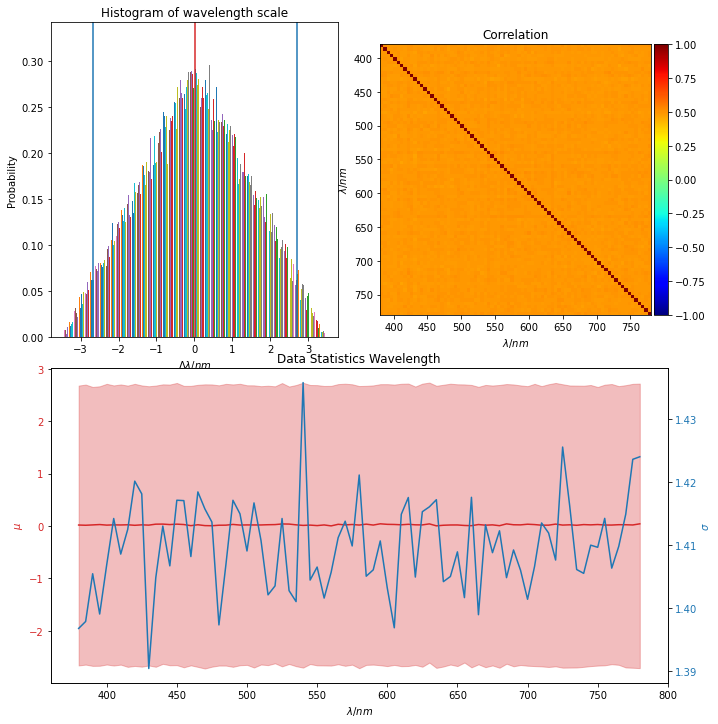

Value= [-9.957582587970072e-05, 0.01413888336691635] Inteval(95%)= 0.05545074581528109
Statistic for the value scale


<ipython-input-3-4ec7dd435c2c>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Value= [-9.957582587970072e-05, 0.01413888336691635] Inteval(95%)= 0.05545074581528109


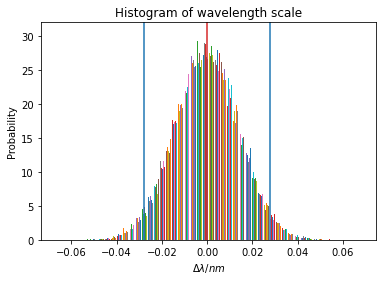

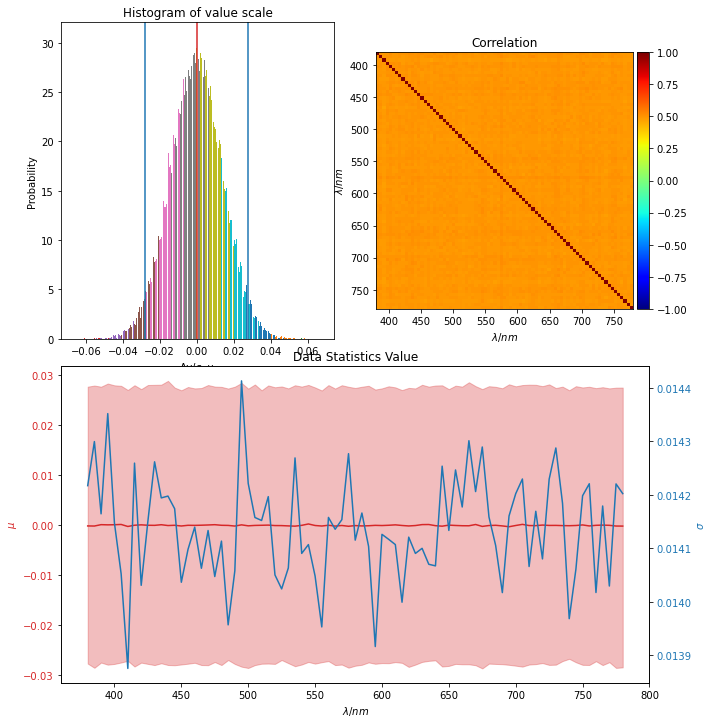

Value= [-9.957582587970072e-05, 0.01413888336691635] Inteval(95%)= 0.05545074581528109
Statistic for the scalar result
Value= [5.896249745671523, 2.129435601625899] Inteval(95%)= 8.079925018177358


<ipython-input-3-4ec7dd435c2c>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


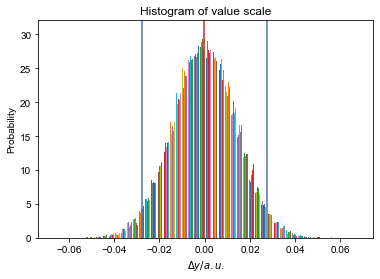

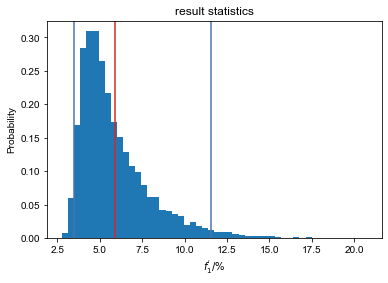

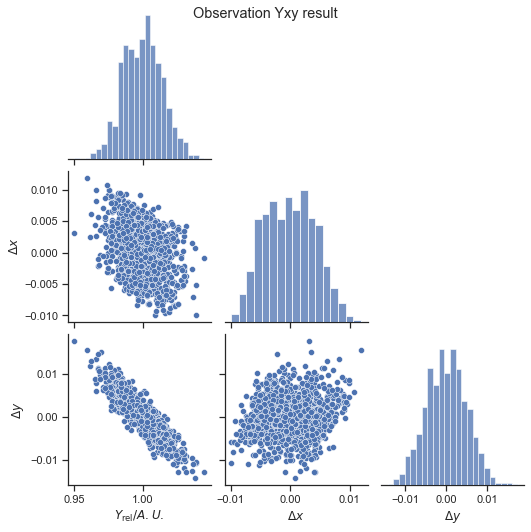

In [8]:
lxCmf = lx._CMF['1931_2']
lxCmfInterpolate = lx.cie_interp(lxCmf['bar'], \
    wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
    kind = 'S')
res = len(lxCmfInterpolate[0])

wl=lxCmfInterpolate[0].reshape(1,res)
value=lxCmfInterpolate[2].reshape(1,res)
spd_init = np.r_[wl, value]

mc_enable = { 'wl_noise_nc': True,
              'wl_noise_c': True,
              'value_noise_nc': True,
              'value_noise_c': True,
              'all': True,
              }

array_mc = np.ndarray((trials,),dtype=object)
result1 = np.zeros( trials)
result3 = np.zeros( (3, trials))

for iMC in ['all']:
#for iMC in mc_enable:
    if mc_enable[iMC] == False: continue

    result1.fill(0)
    result3.fill(0)

    for i in range(trials):
        array_mc[i] = McSpectrumX(spd_init)

    for i in range(0, trials):
        # no noise for the first item as reference for later investigations
        if i != 0:
            if mc_enable['wl_noise_nc'] and (iMC == 'wl_noise_nc' or iMC == 'all'):
                #print( 'wl_noise_nc')
                array_mc[i].add_wl_noise_nc( 0., 1., distribution='uniform')
            if mc_enable['wl_noise_c'] and (iMC == 'wl_noise_c' or iMC == 'all'):
                #print( 'wl_noise_c')
                array_mc[i].add_wl_noise_c( 0., 1., distribution='uniform')
            if mc_enable['value_noise_nc'] and (iMC == 'value_noise_nc' or iMC == 'all'):
                #print( 'value_noise_nc')
                array_mc[i].add_value_noise_nc( 0., 0.01, distribution='normal')
            if mc_enable['value_noise_c'] and (iMC == 'value_noise_c' or iMC == 'all'):
                #print( 'value_noise_c')
                array_mc[i].add_value_noise_c( 0., 0.01, distribution='normal')

        result1[i] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value)
        result3[:,i] = lx.xyz_to_Yxy(array_mc[i].spd.to_xyz(relative=False).value)


print("i=", iMC)
scale_to_reference = True

analyse = array2analyse(array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
print('Statistic for the wavelength scale')
analyse_stat( array_mc, wavelength_stat = True, scale_to_ref=scale_to_reference)
plotHistScalesWl( analyse)

print('Statistic for the value scale')
analyse_stat( array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
plotHistScalesValue( analyse)

print('Statistic for the scalar result')
plotHistScales( 100.*result1, title = "result statistics", xLabel="$f_{1}^{'} / \%$")
seaborn_plot_result( result3)

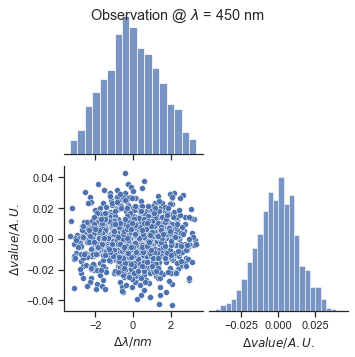

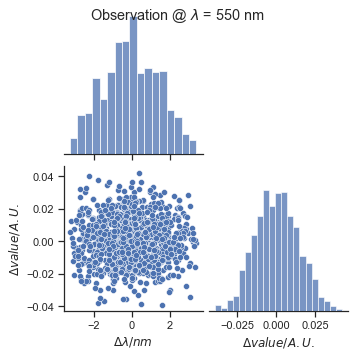

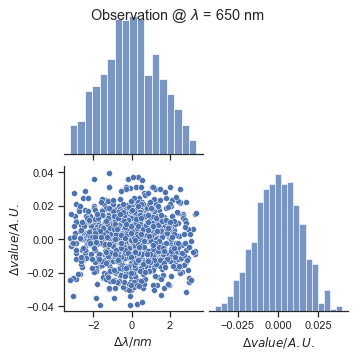

In [9]:
seaborn_plot_basedata(array_mc, wavelength_to_observe = 450)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 550)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 650)

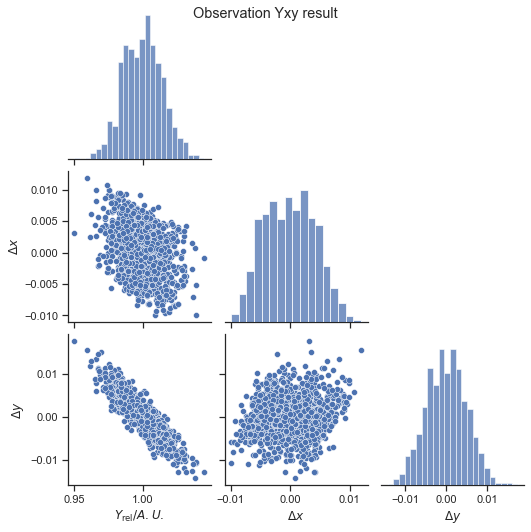

In [10]:
seaborn_plot_result( result3)

In [11]:
#mcComponents = 4
#
#array = np.ndarray((trials,),dtype=object)
#for i in range(trials):
#    array[i] = McSpectrumX(spd_init)
#
#for iMC in range(mcComponents):
#    for jMC in range(iMC,mcComponents):
#        print (iMC, jMC)
#        str = 'MCFile_{}_{}'
#        fileName = str.format(iMC, jMC)
#        np.save( fileName, array)
#

Value= [0.021729918891758907, 1.4098928820905374] Inteval(95%)= 5.363569136817034


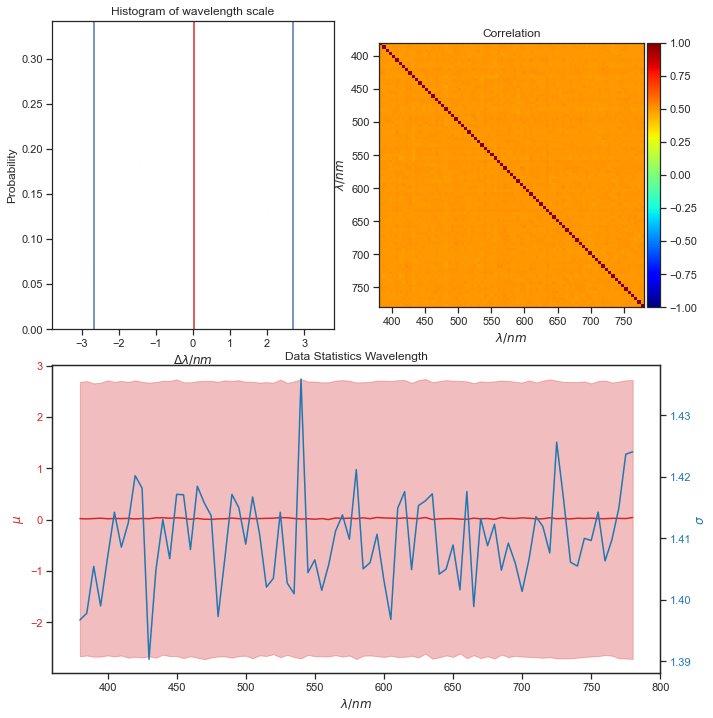

Value= [-9.957582587970072e-05, 0.01413888336691635] Inteval(95%)= 0.05545074581528109


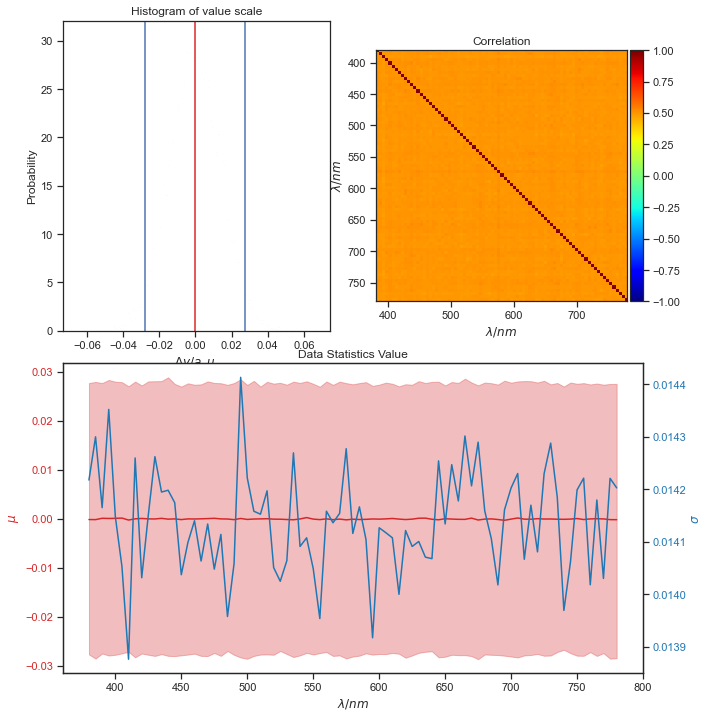

In [12]:
analyse2 = array2analyse(array_mc, wavelength_stat = False, scale_to_ref=True)
[result_sum_mcv2, interval2] = sumMCV(analyse2, Coverage=0.95)
analyse_stat( array_mc, wavelength_stat = True, scale_to_ref=True)
analyse_stat( array_mc, wavelength_stat = False, scale_to_ref=True)